In [1]:
%reset -sf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib.dates import MonthLocator, DateFormatter
from datetime import datetime, date
from IPython.display import Markdown as md

In [2]:
import pickle
dump_fn = 'dwd_csn.pickle'

# with open(dump_fn, 'wb') as f:df = csn_dict[sid][csn_year]['season']
# tmk = df[mvar][['mean','std','min','25%','50%','75%','max']]

#     # Pickle the dictionary using the highest protocol available.
#     pickle.dump(csn_dict, f, pickle.HIGHEST_PROTOCOL)

with open(dump_fn, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    csn_dict = pickle.load(f)

In [3]:
# len(csn_dict) # 09/12/2023 finds 420 weather stations that could be analyzed
# csn_dict.keys()

In [4]:
url = "https://opendata.dwd.de/"
path = 'climate_environment/CDC/observations_germany/climate/daily/kl/'
recent_path = path + 'recent/'
historical_path = path + 'historical/'
filename = 'KL_Tageswerte_Beschreibung_Stationen.txt' 
ws = pd.read_csv(url + recent_path + filename, sep="\t", header=0, skiprows = 0, encoding = "ISO-8859-1").dropna()
ws.drop(0, inplace=True)

# save original column names
colnames = ws.columns[0].split(' ')

# rename column for instance to 'dummy'
ws.columns = ['dummy']

# split string up to 6th column
ws = ws['dummy'].str.split('\s+', n=6, expand=True)

# convert 1:6 to numeric
for col in  ws.iloc[:,1:6]:
    ws[col] = pd.to_numeric(ws[col], errors='coerce') 
    
# concat columns back to a type consistent dataframe
wst = pd.concat([ws.iloc[:,0:6], ws[6].str.slice(0,41), ws[6].str.slice(41,)], axis=1)  
wst.columns = colnames
wst = wst.drop(['von_datum','bis_datum','Stationshoehe','geoBreite','geoLaenge'], axis=1)
# wst

In [5]:
# csn_dict.keys()

In [6]:
# CSN period, Stationsname, and Bundesland
csn_year = 2020
leap_year = 2000 # define an arbitrary leap year for seasonality calendar
sid = '01420'
# sid = '03056'
labels = wst.loc[wst['Stations_id'] == sid, ['Stationsname','Bundesland']]
sname = labels.iloc[0,0].strip()
bland = labels.iloc[0,1].strip()
#
# Daily means
# VPM   : vapor pressure
# PM    : pressure
# TMK   : temperature
# UPM   : relative humidity
mvar = "TMK"

In [7]:
DF = csn_dict[sid][csn_year]['season']
df = DF[mvar][['mean','std','min','25%','50%','75%','max']]

df = df.reset_index() 
df['YEAR'] = leap_year
df['datum'] = pd.to_datetime(dict(year=df['YEAR'], month=df['MONTH'], day=df['DAY'])) 
df = df.drop(['DAY','MONTH','YEAR'], axis=1)
pd.options.display.float_format = '{:.2f}'.format
# df

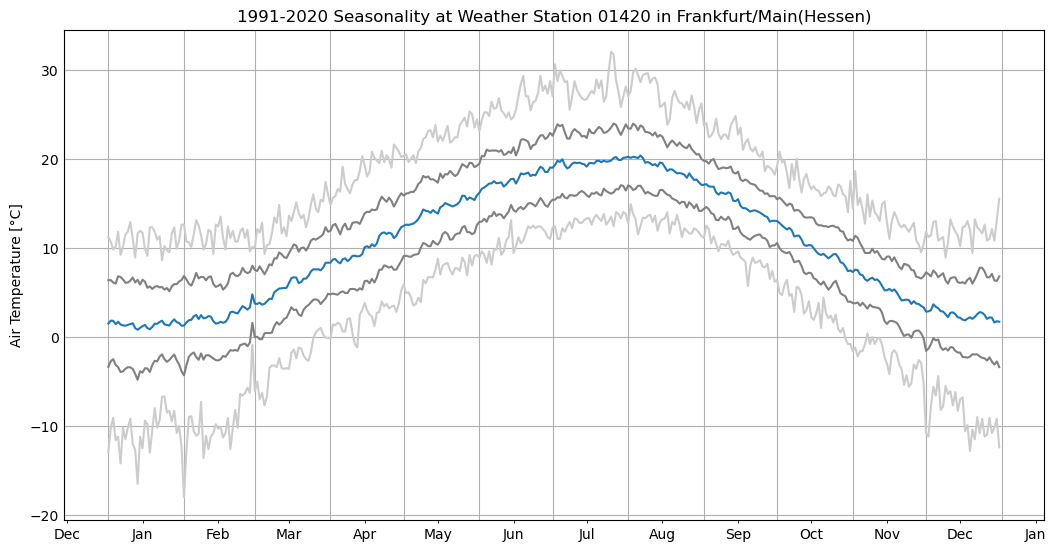

In [8]:
plt.style.use('_mpl-gallery')
fswidth = 10
fsheight = 5
fig, axs = plt.subplots(figsize=(fswidth, fsheight))

xdates = df['datum']
axs.plot(xdates, df['mean'])
axs.plot(xdates, df['mean']+df['std'], color='0.5')
axs.plot(xdates, df['mean']-df['std'], color='0.5')
# axs.plot(xdates, df['25%'], color='0.8')
# axs.plot(xdates, df['50%'], color='0.8')
# axs.plot(xdates, df['75%'], color='0.8')
axs.plot(xdates, df['min'], color='0.8')
axs.plot(xdates, df['max'], color='0.8')

# formatters' options
axs.xaxis.set_major_locator(MonthLocator())
axs.xaxis.set_minor_locator(MonthLocator(bymonthday=15))
axs.xaxis.set_major_formatter(NullFormatter())
axs.xaxis.set_minor_formatter(DateFormatter('%b'))

plt.ylabel('Air Temperature [°C]')
plt.title(f'{csn_year-29}-{csn_year} Seasonality at Weather Station {sid} in {sname}({bland})')
# plt.legend(bbox_to_anchor=(0.5, 0.2), loc='lower center')
plt.show()

In [9]:
# df

In [10]:
# https://www.dunderdata.com/blog?tag=pandas
# https://www.dunderdata.com/blog/displaying-pandas-dataframes-horizontally-in-jupyter-notebooks

from IPython.display import display_html
def display_dfs(dfs, gap=50, justify='center'):
    html = ""
    for title, df in dfs.items():  
        df_html = df._repr_html_()
        cur_html = f'<div> <h3>{title}</h3> {df_html}</div>'
        html +=  cur_html
    html= f"""
    <div style="display:flex; gap:{gap}px; justify-content:{justify};">
        {html}
    </div>
    """
    display_html(html, raw=True)

In [43]:
# https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas
pd.options.mode.chained_assignment = None  # default='warn'
dfs = df[['datum','mean','std']]
dfs.index = dfs.index + 1

winter = dfs.loc[dfs['datum'].between(datetime(leap_year, 1, 1), datetime(leap_year, 3, 31))]
winter['datum'] = winter['datum'].dt.strftime('%d-%b')
spring = dfs.loc[dfs['datum'].between(datetime(leap_year, 4, 1), datetime(leap_year, 6, 30))]
spring['datum'] = spring['datum'].dt.strftime('%d-%b')
summer = dfs.loc[dfs['datum'].between(datetime(leap_year, 7, 1), datetime(leap_year, 9, 30))]
summer['datum'] = summer['datum'].dt.strftime('%d-%b')
autumn = dfs.loc[dfs['datum'].between(datetime(leap_year, 10, 1), datetime(leap_year, 12, 31))]
autumn['datum'] = autumn['datum'].dt.strftime('%d-%b')

dfs = {':...': winter, '.:..': spring, '..:.': summer, '...:': autumn}
pd.options.display.max_rows = None

display_dfs(dfs, justify='flex-start')

,datum,mean,std
1,01-Jan,1.49,4.86
2,02-Jan,1.82,4.55
3,03-Jan,1.80,4.30
4,04-Jan,1.43,4.56
5,05-Jan,1.70,5.10
6,06-Jan,1.39,5.33
7,07-Jan,1.29,5.16
8,08-Jan,1.25,4.83
9,09-Jan,1.34,4.75
10,10-Jan,1.44,4.86
